## EV Charging Analysis

This code performs an analysis of energy prices based on a dataset containing energy price information. The data is loaded into a DataFrame named df_energyPrice using the Pandas library. The code calculates the utilization of charging points based on the ratio between the number of cars and the number of charging points. It then filters the dataset based on a specific date range, considering only weekdays (Monday to Friday) and the specified charging start and end hours. The code also calculates the charging power, charging volume, and time required to charge all cars. It then computes the charging consumption based on the charging time and the corresponding energy price.

Next, the code defines two functions, calculate_consumption_above1 and calculate_consumption_below1, to calculate the charging consumption based on whether the number of hours is greater than or less than 1. These functions iterate over the rows of the DataFrame and calculate the consumption for the hours within the integer and decimal parts of the charging time.

Next, the code defines the calculate_normal_consumption function to calculate the normal consumption based on the integer and decimal parts of the charging time. It rounds the decimal values, creates the 'normal consumption' column, and fills the values based on conditions.

Finally, the code converts the 'Hour' column to a string data type, creates a new column named 'DateTime' by concatenating the 'Date' and 'Hour' columns, converts the 'DateTime' column to a datetime data type, and redefines the DataFrame index.

Main objectives:

- Create a normal ('dumb') charge profile
- Make the charging profile smart based on Day-Ahead electricity price
- Calculate the cost saving for purchase of energy

#### Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import calendar

from datetime import datetime, timedelta, date, time
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

#### Read the Price CSV

In [2]:
# Choose what file you want, it's only comment one and uncomment another

# For use a CSV with new data
df_energyPrice = pd.read_csv('C:/Users/Diego Galdino/OneDrive - Groene Cadans B.V/Algorithms/Energy-Price-ENTSOE/EntsoeEnergyPrice.csv')

# For use a CSV already in the folder
# df_energyPrice = pd.read_csv('EV_Charging_Analysis.csv')

#### Parameters

In [3]:
# Choose whether you want automatic input or input every time the script restarts. 
# Just comment out one option and uncomment the other.

# Number of cars charging
n = 2 # Automatic
#n = int(input("Number of cars charging: "))  # User-defined

# Number of charging point
cp = 2 # Automatic
#cp = int(input("Number of charging points: "))  # User-defined

# Utilisation of charging point
U = n/cp  

# Time to charge
start_time = pd.to_datetime('8:00').time()  # Start charging 
end_time = pd.to_datetime('20:00').time()  # Finish charging

# Filter the dates between 2022-01-01 and 2022-12-31
start_date = pd.to_datetime('2022-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()

In [4]:
# Create a copy of the DataFrame containing the desired columns and filtering by the specified dates
df_copy = df_energyPrice.loc[
    (pd.to_datetime(df_energyPrice['Date']).dt.date >= start_date) & 
    (pd.to_datetime(df_energyPrice['Date']).dt.date <= end_date),
    ['Date', 'Hour', 'Import Grid (EUR/kWh)']
].copy()

# Convert the 'Date' column to datetime
df_copy['Date'] = pd.to_datetime(df_copy['Date'])

# Remove the seconds from the 'Hour' column
df_copy['Hour'] = df_copy['Hour'].str[:5]

# Convert the 'Hour' column to datetime.time format
df_copy['Hour'] = pd.to_datetime(df_copy['Hour'], format='%H:%M').dt.time

# Filter weekdays (Monday to Friday)
weekdays = [0, 1, 2, 3, 4]
df = df_copy[df_copy['Date'].dt.weekday.isin(weekdays)]

# Filter the DataFrame by hour range
df = df[(df['Hour'] >= start_time) & (df['Hour'] <= end_time)]

# Reset the index of the filtered DataFrame
df.reset_index(drop=True, inplace=True)

#### Calculation of Charging Volume and Power, and hours to charge

In [5]:
# Charging power in kW
P = cp * U * 75 

# Charging volume in kWh
E = cp * U * 30 

# Calculate number of hours
num_hours = (E / P)
integer_hours = int(num_hours)
decimal_hours = num_hours - integer_hours

#### Print Information

In [6]:
print('Year: 2021')
print('Car Charging:', n)
print('Charging Points:', cp)
print('Utilization: ', U*100,'%')
print('Charging Power:', P, 'kW (P = cp * U * 75)')
print('Charging Volume:', E, 'kWh (E = cp * U * 30)')
print('Time for charging all cars:', num_hours, 'H')

Year: 2021
Car Charging: 2
Charging Points: 2
Utilization:  100.0 %
Charging Power: 150.0 kW (P = cp * U * 75)
Charging Volume: 60.0 kWh (E = cp * U * 30)
Time for charging all cars: 0.4 H


#### Functions

In [7]:
def calculate_consumption_above1(df, start_time, integer_hours,decimal_hours, P):
    ### INTEGER PART
    df['integer'] = np.nan
    df['decimal'] = np.nan
    # Convert start_time to a datetime object
    start_datetime = datetime.combine(datetime.today().date(), start_time)

    # Calculate new_end_datetime by adding integer_hours to start_datetime
    new_end_datetime = start_datetime + timedelta(hours=integer_hours)

    # Extract the time component from new_end_datetime
    new_end_time = new_end_datetime.time()

    # Create a mask to identify rows where Hour is between start_time and new_end_time
    mask = (df['Hour'] >= start_time) & (df['Hour'] < new_end_time)

    # Calculate the charging consumption based on the condition
    df['integer'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * P

    ### DECIMAL PART
    # Convert new_end_time to a datetime object
    start_datetime = datetime.combine(datetime.today().date(), new_end_time)

    # Calculate new_end_datetime by adding integer_hours to start_datetime
    new_end_datetime = start_datetime + timedelta(hours=np.ceil(decimal_hours))

    # Extract the time component from new_end_datetime
    new_end_time = new_end_datetime.time()

    # Create a mask to identify rows where Hour is between start_time and new_end_time
    mask = (df['Hour'] > start_time) & (df['Hour'] < new_end_time)
       
    # Calculate the charging consumption based on the condition
    df['decimal'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * (P * decimal_hours)

    return df

In [8]:
def calculate_consumption_below1(df, start_time, integer_hours,decimal_hours, P):
    ### INTEGER PART
    # Fill the 'integer' column with NaN
    df['integer'] = np.nan
    df['decimal'] = np.nan
    
    ### DECIMAL PART
    # Convert start_time to a datetime object
    start_datetime = datetime.combine(datetime.today().date(), start_time)

    # Calculate new_end_datetime by adding decimal_hours to start_datetime
    new_end_datetime = start_datetime + timedelta(hours=decimal_hours)

    # Extract the time component from new_end_datetime
    new_end_time = new_end_datetime.time()

    # Create a mask to identify rows where Hour is between start_time and new_end_time
    mask = (df['Hour'] >= start_time) & (df['Hour'] < new_end_time)
       
    # Calculate the charging consumption based on the condition
    df['decimal'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * (P * decimal_hours)
    
    return df

In [9]:
def calculate_normal_consumption(df):
    # Round decimal values to 5 decimal places
    df['integer'] = df['integer'].round(5)
    df['decimal'] = df['decimal'].round(5)

    # Replace 'nan' with empty strings in the 'integer' and 'decimal' columns
    df['integer'] = df['integer'].fillna('')
    df['decimal'] = df['decimal'].fillna('')

    # Create the 'normal consumption' column with empty values
    df['normal consumption'] = ''

    # Fill values in the 'normal consumption' column based on the conditions
    df.loc[(df['integer'] == '') & (df['decimal'] == ''), 'normal consumption'] = ''
    df.loc[(df['integer'] != '') & (df['decimal'] == ''), 'normal consumption'] = df['integer']
    df.loc[(df['integer'] != '') & (df['decimal'] != ''), 'normal consumption'] = df['integer']
    df.loc[(df['integer'] == '') & (df['decimal'] != ''), 'normal consumption'] = df['decimal']

    # Drop the 'integer' and 'decimal' columns
    df = df.drop(['integer', 'decimal'], axis=1)

    # Convert the 'normal consumption' column to float type
    df['normal consumption'] = pd.to_numeric(df['normal consumption'], errors='coerce')

    return df

### Normal Charging

In [10]:
# Convert the string 'HH:MM' to a time object
start_time = time.fromisoformat('08:00')

if integer_hours != 0:
    df = calculate_consumption_above1(df, start_time, integer_hours,decimal_hours, P)
else:
    df = calculate_consumption_below1(df, start_time, integer_hours,decimal_hours, P)

df = calculate_normal_consumption(df)

### Smart Charging

In [11]:
# Convert the 'Hour' column to string data type
df['Hour'] = df['Hour'].astype(str)

# Concatenate the 'Date' and 'Hour' into a single column
df['DateTime'] = df['Date'].astype(str) + ' ' + df['Hour']

# Convert the 'DateTime' column to datetime data type
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Reset the index and add the 'index' column
df.reset_index(inplace=True)
df.rename(columns={'index': 'index'}, inplace=True)

# Group the dataframe by 'Date'
grouped_df = df.groupby('Date')

index_values = []  # List to store the values of the new 'index' column

for _, group in grouped_df:
    mask = (group['DateTime'].dt.hour >= 8) & (group['DateTime'].dt.hour <= 12)
    lowest_import_date = group.loc[mask, 'Import Grid (EUR/kWh)'].idxmin()
    if pd.notnull(lowest_import_date):  # Verificar se o valor não é nulo
        index_value = group.loc[lowest_import_date, 'index']
        index_values.append(index_value)

# Reset the index
df = df.reset_index(drop=True)

# Fill the 'integer' and 'decimal' columns based on conditions
for index_value in index_values:
    if index_value in df['index'].values:
        # Calculate the consumption for non-zero 'integer_hours'
        integer_hours = int(integer_hours)
        
        if integer_hours != 0:
            final_value = index_value + integer_hours
        
            mask = (df['index'] >= index_value) & (df['index'] < final_value)
            df.loc[mask, 'integer'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * P
            
            mask = (df['index'] > index_value) & (df['index'] <= final_value)
            df.loc[mask, 'decimal'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * (P * decimal_hours)
        else:
            mask = (df['index'] == index_value)
            df.loc[mask, 'decimal'] = df.loc[mask, 'Import Grid (EUR/kWh)'] * (P * decimal_hours)
            df.loc[mask, 'integer'] = float('nan')

# Calculate the 'smart consumption' column based on 'normal consumption', 'integer', and 'decimal' columns
df['smart consumption'] = df['integer'].fillna(0) + df['decimal'].fillna(0)
df.loc[df['smart consumption'] == 0, 'smart consumption'] = np.nan

# Drop unnecessary columns
df = df.drop(['integer', 'decimal', 'index', 'DateTime'], axis=1)

### Analysis

#### Monthly Consumption

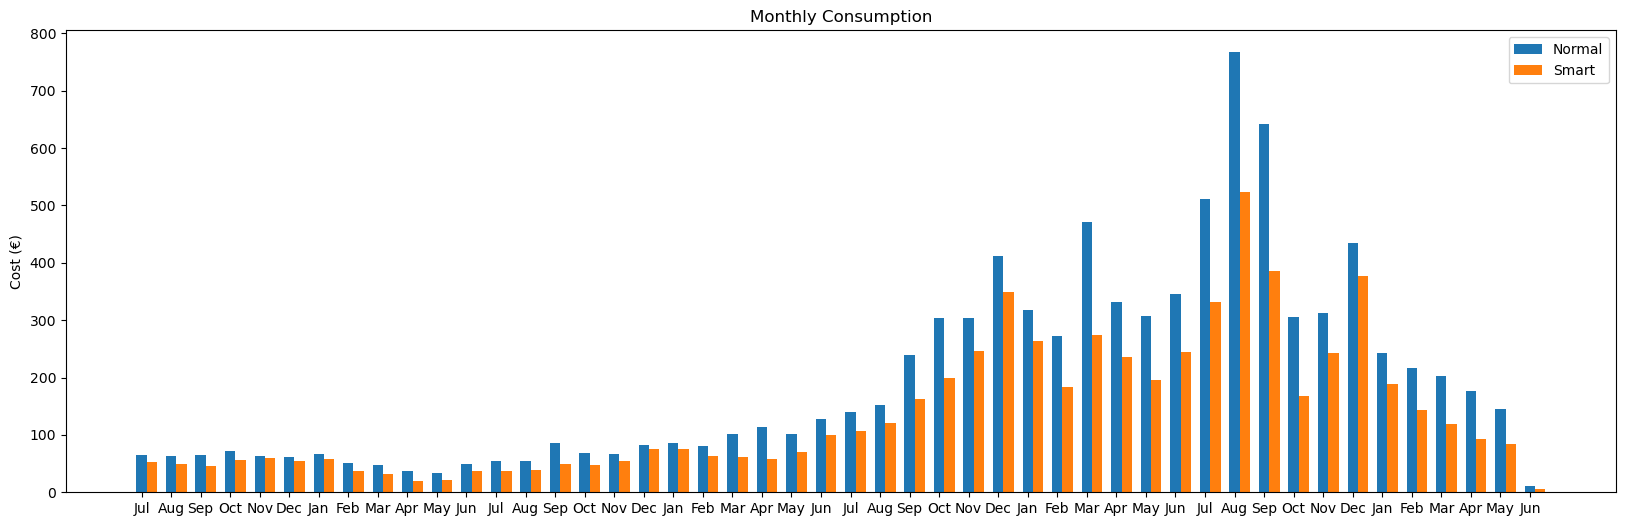

In [12]:
# Make a copy of df
df_month = df.copy()

# Convert the 'Date' column to datetime type
df_month['Date'] = pd.to_datetime(df_month['Date'])

# Extract the year and month from the 'Date' column
df_month['YearMonth'] = df_month['Date'].dt.to_period('M')

# Group the dataframe by month and year and calculate the sum of normal consumption and smart consumption
monthly_data = df_month.groupby('YearMonth').agg({'normal consumption': 'sum', 'smart consumption': 'sum'})

# Reset the index
monthly_data = monthly_data.reset_index()

# Create a figure and axes for the graph
fig, ax = plt.subplots(figsize=(20, 6))

# Get the x-axis values (months)
x = monthly_data['YearMonth'].dt.strftime('%b')

# Get the y-axis values (consumption)
normal_consumption = monthly_data['normal consumption']
smart_consumption = monthly_data['smart consumption']

# Set the width of the bars
bar_width = 0.35

# Position the bars on the x-axis
bar_positions1 = range(len(x))
bar_positions2 = [x + bar_width for x in bar_positions1]

# Create the bar plots
ax.bar(bar_positions1, normal_consumption, width=bar_width, label='Normal')
ax.bar(bar_positions2, smart_consumption, width=bar_width, label='Smart')

# Set the x-axis labels as the months
ax.set_xticks(bar_positions1)
ax.set_xticklabels(x)

# Add a label to the y-axis
plt.ylabel('Cost (€)')

# Add a title to the graph
ax.set_title('Monthly Consumption')

# Add a legend
ax.legend()

# Save the Graph
plt.savefig('Monthly Consumption.png')

# Display the graph
plt.show()

### Yearly Consumption

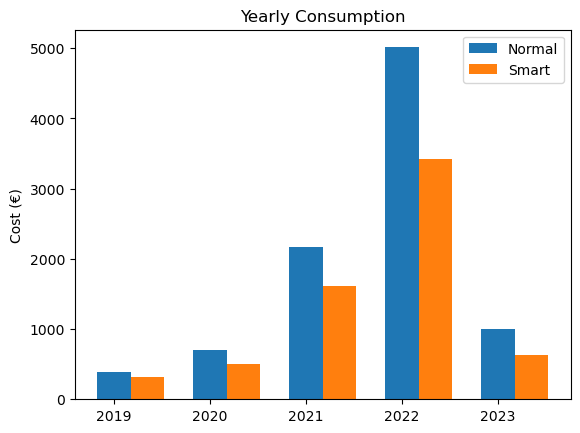

In [13]:
# Make a copy of df
df_year = df.copy()

# Extract the year from the 'Date' column
df_year['Year'] = df_year['Date'].dt.year

# Group the dataframe by year and calculate the sum of normal consumption and smart consumption
yearly_data = df_year.groupby('Year').agg({'normal consumption': 'sum', 'smart consumption': 'sum'})

# Reset the index
yearly_data = yearly_data.reset_index()

# Create a figure and axes for the graph
fig, ax = plt.subplots()

# Get the x-axis values (years)
x = yearly_data['Year'].astype(str)

# Get the y-axis values (consumption)
normal_consumption = yearly_data['normal consumption']
smart_consumption = yearly_data['smart consumption']

# Set the width of the bars
bar_width = 0.35

# Position the bars on the x-axis
bar_positions1 = range(len(x))
bar_positions2 = [x + bar_width for x in bar_positions1]

# Create the bar plots
ax.bar(bar_positions1, normal_consumption, width=bar_width, label='Normal')
ax.bar(bar_positions2, smart_consumption, width=bar_width, label='Smart')

# Set the x-axis labels as the years
ax.set_xticks(bar_positions1)
ax.set_xticklabels(x)

# Add a title to the graph
ax.set_title('Yearly Consumption')
plt.ylabel('Cost (€)')

# Add a legend
ax.legend()

#Save the Graph
plt.savefig('Yearly Consumption.png')

# Display the graph
plt.show()

In [14]:
total_normal_cost = df['normal consumption'].sum()
total_smart_cost = df['smart consumption'].sum()
total_cost_saving = total_normal_cost - total_smart_cost

# Calculate cost per kWh for normal consumption
df['cost/kWh normal'] = df['normal consumption'] / E
cost_normal_mean =df['cost/kWh normal'].sum()

# Calculate cost per kWh for smart consumption
df['cost/kWh smart'] = df['smart consumption'] / E
cost_smart_mean =df['cost/kWh smart'].sum()

# Calculate statistics for 'cost/kWh normal'
cost_normal_max = df['cost/kWh normal'].max()
cost_normal_min = df['cost/kWh normal'].min()
cost_normal_mean = df['cost/kWh normal'].mean()

# Calculate statistics for 'cost/kWh smart'
cost_smart_max = df['cost/kWh smart'].max()
cost_smart_min = df['cost/kWh smart'].min()
cost_smart_mean = df['cost/kWh smart'].mean()

In [15]:
#Format the cost values with two decimal places and the Euro symbol
total_normal_cost_formatted = f"€{total_normal_cost:.2f}"
total_smart_cost_formatted = f"€{total_smart_cost:.2f}"
total_cost_saving_formatted = f"€{total_cost_saving:.2f}"

print('Total cost of normal consumption:', total_normal_cost_formatted)
print('Total cost of smart consumption:', total_smart_cost_formatted)
print('Total cost saving:', total_cost_saving_formatted)

Total cost of normal consumption: €9257.88
Total cost of smart consumption: €6498.38
Total cost saving: €2759.50


In [16]:
# Print the comparison of statistics between 'cost/kWh normal' and 'cost/kWh smart'
print('\nStatistics comparison:')
print('Max cost/kWh:')
print('Normal: {:.5f}'.format(cost_normal_max))
print('Smart: {:.5f}'.format(cost_smart_max))

print('\nMin cost/kWh:')
print('Normal: {:.5f}'.format(cost_normal_min))
print('Smart: {:.5f}'.format(cost_smart_min))

print('\nMean cost/kWh:')
print('Normal: {:.5f}'.format(cost_normal_mean))
print('Smart: {:.5f}'.format(cost_smart_mean))


Statistics comparison:
Max cost/kWh:
Normal: 0.80298
Smart: 0.69990

Min cost/kWh:
Normal: 0.01096
Smart: 0.00001

Mean cost/kWh:
Normal: 0.15098
Smart: 0.10597


#### Monthly Cost-kWh and Consumption

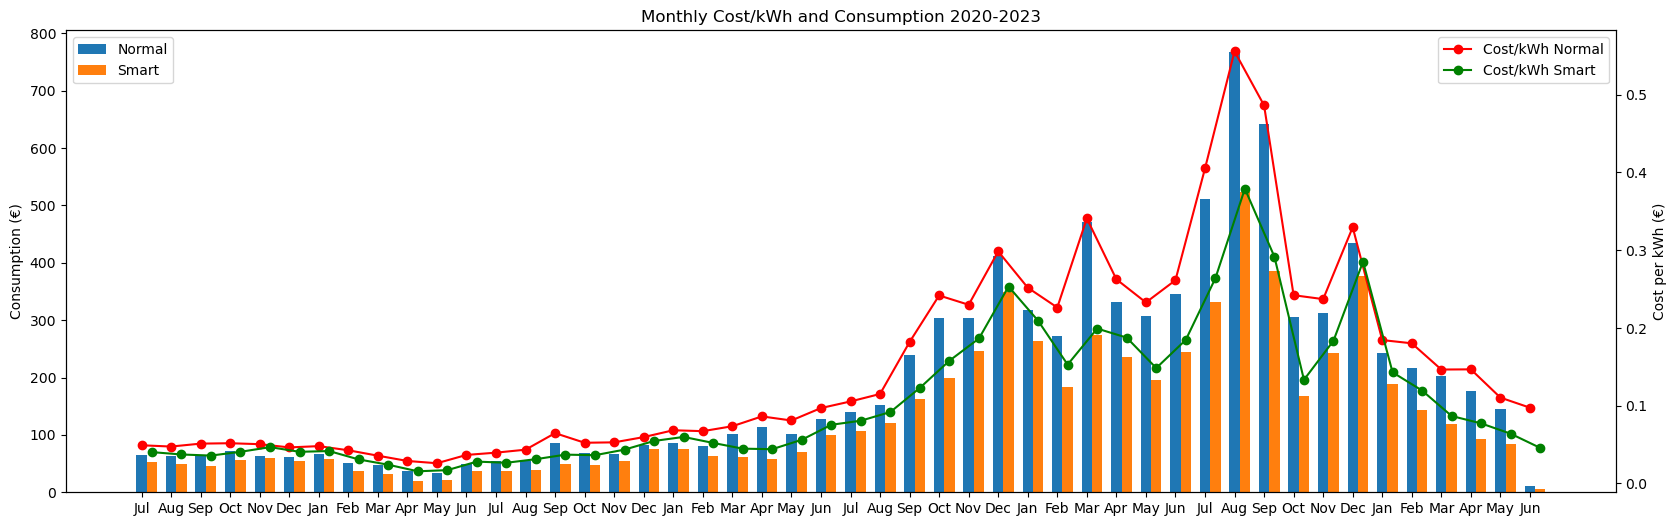

In [17]:
#The Graph will appear in a external windows

# Create a new DataFrame that contains df e df_month
df_cost = pd.merge(df, df_month, on=['Date', 'Hour', 'Import Grid (EUR/kWh)', 'normal consumption', 'smart consumption'], how='outer')

#%matplotlib qt
# Get the x-axis values (months)
x = monthly_data['YearMonth'].dt.strftime('%b')

# Get the y-axis values (consumption)
normal_consumption = monthly_data['normal consumption']
smart_consumption = monthly_data['smart consumption']

# Get the cost per kWh values
cost_per_kWh_normal = df_cost.groupby('YearMonth')['cost/kWh normal'].mean()
cost_per_kWh_smart = df_cost.groupby('YearMonth')['cost/kWh smart'].mean()

# Create a figure and axes for the graph
fig, ax = plt.subplots(figsize=(20, 6))

# Set the width of the bars
bar_width = 0.35

# Position the bars on the x-axis
bar_positions1 = np.arange(len(x))
bar_positions2 = [x + bar_width for x in bar_positions1]

# Create the bar plots for consumption
ax.bar(bar_positions1, normal_consumption, width=bar_width, label='Normal')
ax.bar(bar_positions2, smart_consumption, width=bar_width, label='Smart')

# Set the x-axis labels as the months
ax.set_xticks(bar_positions1)
ax.set_xticklabels(x)

# Create a second y-axis
ax2 = ax.twinx()

# Plot the cost per kWh values
ax2.plot(bar_positions1, cost_per_kWh_normal, label='Cost/kWh Normal', color='red', marker='o')
ax2.plot(bar_positions2, cost_per_kWh_smart, label='Cost/kWh Smart', color='green', marker='o')

# Add a label to the y-axis
ax.set_ylabel('Consumption (€)')
ax2.set_ylabel('Cost per kWh (€)')

# Add a title to the graph
ax.set_title('Monthly Cost/kWh and Consumption 2020-2023')

# Add a legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

#Save the Graph
plt.savefig('Monthly Cost-kWh and Consumption.png')

# Display the graph
plt.show()

#### Monthly Average kWh Cost Analysis 

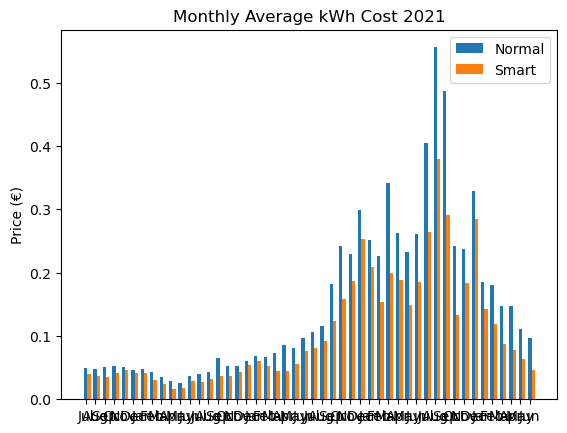

In [18]:
#The Graph will appear in a external windows

# Make a copy of the df_cost
df_average_kwh = df_cost.copy()

# Convert the 'Date' column to datetime type
df_average_kwh['Date'] = pd.to_datetime(df_average_kwh['Date'])

# Extract the year and month from the 'Date' column
df_average_kwh['YearMonthC'] = df_average_kwh['Date'].dt.to_period('M')

# Group the dataframe by month and year and calculate the sum of normal consumption and smart consumption
monthly_data = df_average_kwh.groupby('YearMonthC').agg({'cost/kWh normal': 'mean', 'cost/kWh smart': 'mean'})

# Reset the index
monthly_data = monthly_data.reset_index()

# Create a figure and axes for the graph
fig, ax = plt.subplots()

# Get the x-axis values (months)
x = monthly_data['YearMonthC'].dt.strftime('%b')

# Get the y-axis values (consumption)
normal_cost = monthly_data['cost/kWh normal']
smart_cost = monthly_data['cost/kWh smart']

# Set the width of the bars
bar_width = 0.35

# Position the bars on the x-axis
bar_positions1 = range(len(x))
bar_positions2 = [x + bar_width for x in bar_positions1]

# Create the bar plots
ax.bar(bar_positions1, normal_cost, width=bar_width, label='Normal')
ax.bar(bar_positions2, smart_cost, width=bar_width, label='Smart')

# Set the x-axis labels as the months
ax.set_xticks(bar_positions1)
ax.set_xticklabels(x)

# Add a label to the y-axis
plt.ylabel('Price (€)')

# Add a title to the graph
ax.set_title('Monthly Average kWh Cost 2021')

# Add a legend
ax.legend()

#Save the Graph
plt.savefig('Monthly Average kWh Cost.png')

# Display the graph
plt.show()

#### Trend analysis

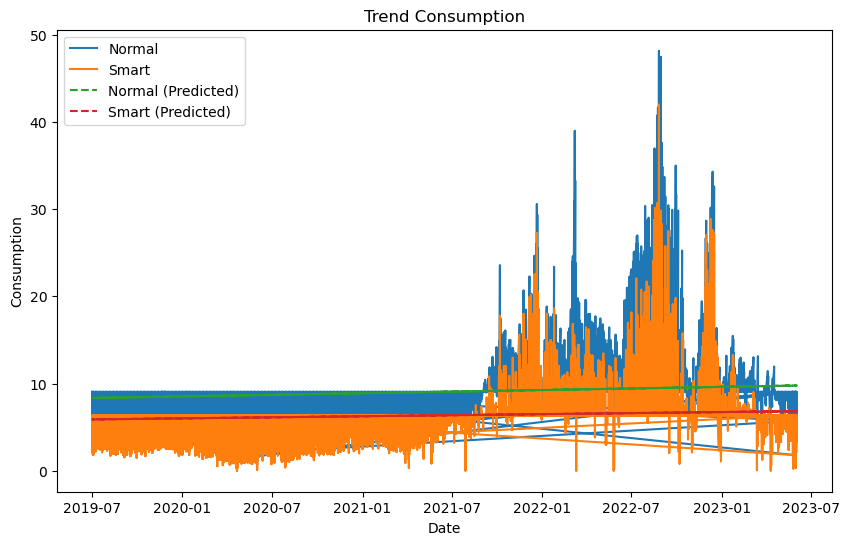

In [19]:
# Make a copy of the DataFrame
df_trend_consumption = df.copy()

# Create a new column of day numbers from the starting date
df_trend_consumption['Days'] = (df_trend_consumption['Date'] - df_trend_consumption['Date'].min()).dt.days

# Create a response variable for normal and smart consumption
y_normal = df_trend_consumption['normal consumption'].fillna(df_trend_consumption['normal consumption'].mean()).values.reshape(-1, 1)
y_smart = df_trend_consumption['smart consumption'].fillna(df_trend_consumption['smart consumption'].mean()).values.reshape(-1, 1)

# Create a feature matrix with the day numbers
X = df_trend_consumption['Days'].values.reshape(-1, 1)

# Create a linear regression model for normal and smart consumption
model_normal = LinearRegression()
model_smart = LinearRegression()

# Fit the model to the data
model_normal.fit(X, y_normal)
model_smart.fit(X, y_smart)

# Make predictions using the fitted model
y_normal_pred = model_normal.predict(X)
y_smart_pred = model_smart.predict(X)

# Plot the actual data and the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_trend_consumption['Date'], y_normal, label='Normal')
plt.plot(df_trend_consumption['Date'], y_smart, label='Smart')
plt.plot(df_trend_consumption['Date'], y_normal_pred, linestyle='--', label='Normal (Predicted)')
plt.plot(df_trend_consumption['Date'], y_smart_pred, linestyle='--', label='Smart (Predicted)')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Trend Consumption')
plt.legend()

#Save the Graph
plt.savefig('Trend Consumption.png')


plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   13299 non-null  datetime64[ns]
 1   Hour                   13299 non-null  object        
 2   Import Grid (EUR/kWh)  13188 non-null  float64       
 3   normal consumption     1022 non-null   float64       
 4   smart consumption      1022 non-null   float64       
 5   cost/kWh normal        1022 non-null   float64       
 6   cost/kWh smart         1022 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 727.4+ KB


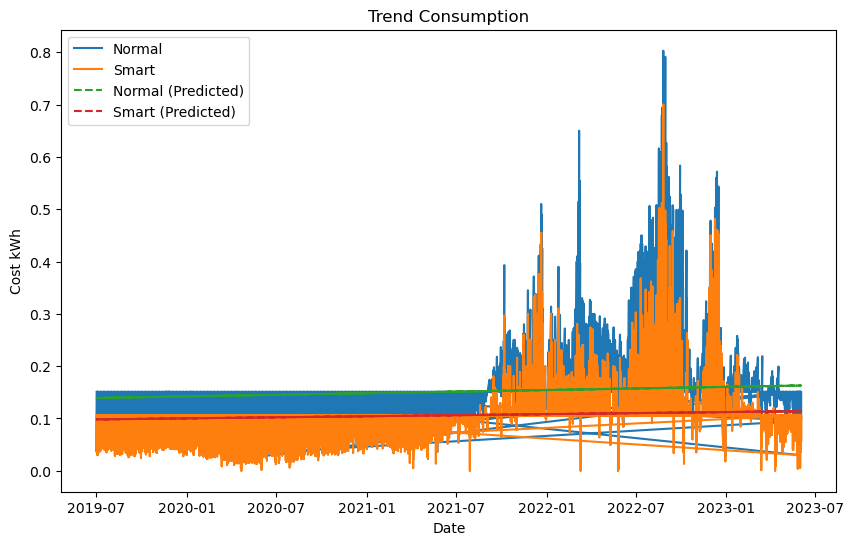

In [21]:
# Make a copy of the DataFrame
df_trend_cost = df.copy()

# Create a new column of day numbers from the starting date
df_trend_cost['Days'] = (df_trend_cost['Date'] - df_trend_cost['Date'].min()).dt.days

# Create a response variable for normal and smart consumption
y_normal = df_trend_cost['cost/kWh normal'].fillna(df_trend_cost['cost/kWh normal'].mean()).values.reshape(-1, 1)
y_smart = df_trend_cost['cost/kWh smart'].fillna(df_trend_cost['cost/kWh smart'].mean()).values.reshape(-1, 1)

# Create a feature matrix with the day numbers
X = df_trend_cost['Days'].values.reshape(-1, 1)

# Create a linear regression model for normal and smart consumption
model_normal = LinearRegression()
model_smart = LinearRegression()

# Fit the model to the data
model_normal.fit(X, y_normal)
model_smart.fit(X, y_smart)

# Make predictions using the fitted model
y_normal_pred = model_normal.predict(X)
y_smart_pred = model_smart.predict(X)

# Plot the actual data and the predictions
plt.figure(figsize=(10, 6))
plt.plot(df_trend_cost['Date'], y_normal, label='Normal')
plt.plot(df_trend_cost['Date'], y_smart, label='Smart')
plt.plot(df_trend_cost['Date'], y_normal_pred, linestyle='--', label='Normal (Predicted)')
plt.plot(df_trend_cost['Date'], y_smart_pred, linestyle='--', label='Smart (Predicted)')
plt.xlabel('Date')
plt.ylabel('Cost kWh')
plt.title('Trend Consumption')
plt.legend()

#Save the Graph
plt.savefig('Trend Cost kWh.png')


plt.show()

#### Seasonal Analysis

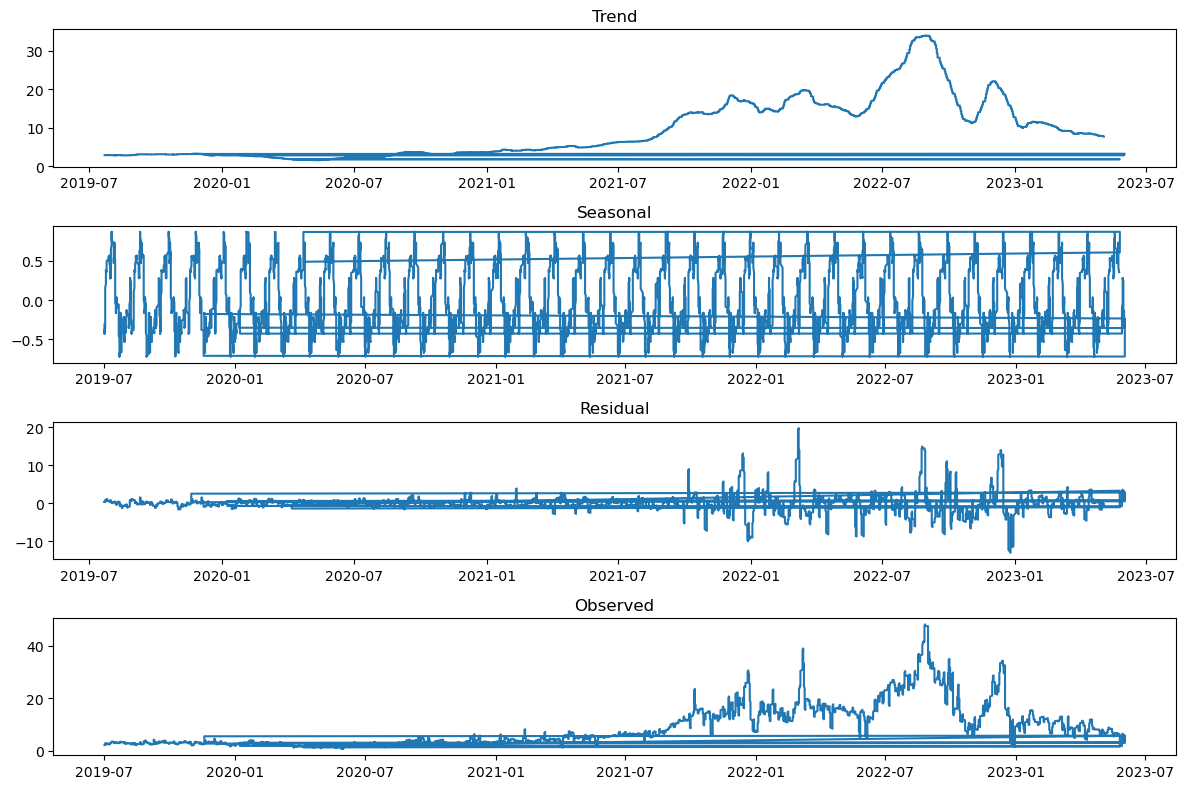

In [22]:
# Make a copy of the DataFrame
df_seasonal = df.copy()

# Preencher valores ausentes com interpolação
df_seasonal['normal consumption'] = df_seasonal['normal consumption'].interpolate()

# Criar um índice de data para o DataFrame
df_seasonal.set_index('Date', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_seasonal['normal consumption'].dropna(), model='additive', period=365)

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.subplot(414)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.tight_layout()
plt.show()

The generated plots represent the components resulting from the seasonal decomposition of the normal consumption data. Here's the interpretation of each of the plots:

- **Trend:** This plot shows the long-term trend of the data, representing the average variation over time, disregarding the seasonal effects. It allows us to identify patterns of growth, decline, or stability in normal consumption over time.

- **Seasonal:** This plot shows the seasonal components of the data, representing the regular fluctuations that occur at fixed intervals of time. It allows us to identify specific seasonal patterns that repeat at regular intervals, such as daily, weekly, monthly, or yearly variations in normal consumption.

- **Residual:** This plot shows the residuals of the decomposition, i.e., the parts of the data that cannot be explained by the trend or the seasonality. It allows us to identify non-seasonal patterns, such as irregular fluctuations, noise, or random patterns in the data.

- **Observed**: This plot shows the original normal consumption data. It is the actual data series before decomposition. It allows us to visualize the complete time series and compare it with the decomposed components.

#### Anomaly Analysis

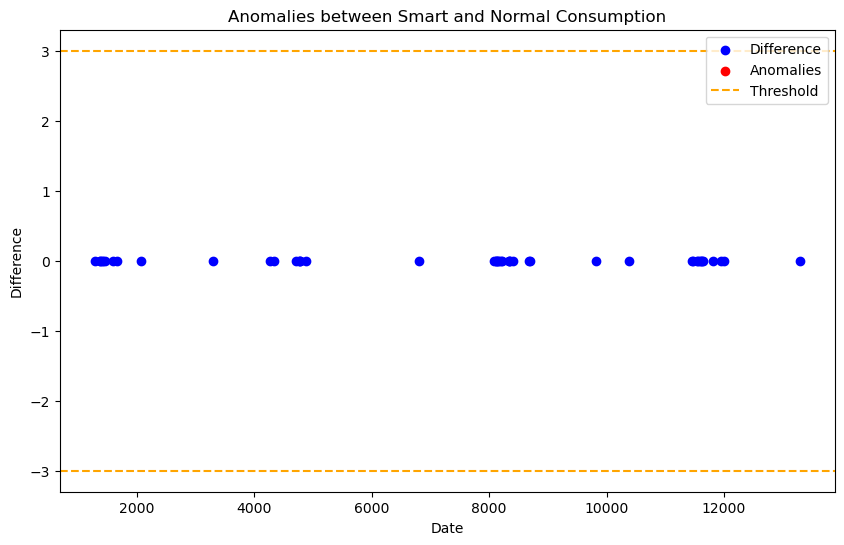

In [23]:
# Make a copy of the DataFrame
df_anomaly = df.copy()

# Calculate the difference between 'smart consumption' and 'normal consumption'
difference = df_anomaly['smart consumption'] - df_anomaly['normal consumption']

# Calculate the z-score for the difference
z_scores = (difference - difference.mean()) / difference.std()

# Define a threshold for anomaly detection (e.g., z-score > 3)
threshold = 3

# Identify anomalies based on the threshold
anomalies = df_anomaly[z_scores > threshold]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_anomaly.index, difference, color='blue', label='Difference')
plt.scatter(anomalies.index, difference[z_scores > threshold], color='red', label='Anomalies')
plt.axhline(threshold, color='orange', linestyle='--', label='Threshold')
plt.axhline(-threshold, color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Anomalies between Smart and Normal Consumption')
plt.legend()
plt.show()

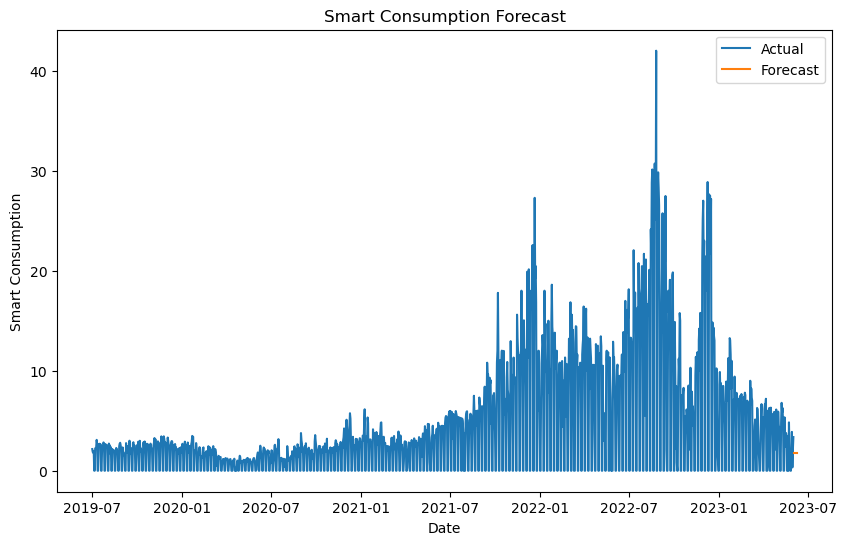

        Date  Forecast
0 2023-06-03  1.812681
1 2023-06-04  1.812681
2 2023-06-05  1.812681
3 2023-06-06  1.812681
4 2023-06-07  1.812681
5 2023-06-08  1.812681
6 2023-06-09  1.812681


In [24]:
# Create a copy of the DataFrame
df_pred = df.copy()

# Prepare the data for modeling
df_pred = df_pred[['Date', 'smart consumption']]
df_pred = df_pred.set_index('Date')
df_pred = df_pred.resample('D').sum()  # Resample to daily frequency

# Split the data into train and test sets
train_data = df_pred.iloc[:-7]  # Use all but the last 7 days for training
test_data = df_pred.iloc[-7:]  # Use the last 7 days for testing

# Fit the ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Perform the forecast
forecast = model_fit.forecast(steps=7)  # Forecast for the next 7 days

# Create a new DataFrame for the forecast results
forecast_dates = pd.date_range(start=df_pred.index[-1] + pd.DateOffset(days=1), periods=7, freq='D')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast[0]})

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_pred.index, df_pred['smart consumption'], label='Actual')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Smart Consumption')
plt.title('Smart Consumption Forecast')
plt.legend()
plt.show()

# Print the forecasted values
print(forecast_df)

In [25]:
# Criar uma cópia do DataFrame
df_copy = df.copy()

# Preencher os valores ausentes com a média
df_copy['normal consumption'].fillna(df_copy['normal consumption'].mean(), inplace=True)

# Converter a coluna 'Hour' para o formato numérico
df_copy['Hour'] = LabelEncoder().fit_transform(df_copy['Hour'])

# Separar os recursos (X) e os rótulos (y) nos conjuntos de treinamento e teste
X_train = df_copy.iloc[:-24]['Hour'].values.reshape(-1, 1)
y_train = df_copy.iloc[:-24]['normal consumption']

X_test = df_copy.iloc[-24:]['Hour'].values.reshape(-1, 1)
y_test = df_copy.iloc[-24:]['normal consumption']

# Instanciar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
predictions = model.predict(X_test)

# Calcular o erro quadrático médio
mse = mean_squared_error(y_test, predictions)

print("Previsões:")
print(predictions)
print("Erro Quadrático Médio:", mse)

Previsões:
[9.06000336 9.05978091 9.05955845 9.059336   9.05911355 9.0588911
 9.05866865 9.0584462  9.05822375 9.0580013  9.05777885 9.06044826
 9.06022581 9.06000336 9.05978091 9.05955845 9.059336   9.05911355
 9.0588911  9.05866865 9.0584462  9.05822375 9.0580013  9.05777885]
Erro Quadrático Médio: 1.980559677900685


#### Save the CSV file

In [26]:
#df.to_csv('EV_Charging_Analysis.csv')